In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

## Data

### Setup

In [3]:
PATH = Path('data/carvana')
list(PATH.iterdir())

[PosixPath('data/carvana/train.zip'),
 PosixPath('data/carvana/sample_submission.csv'),
 PosixPath('data/carvana/train_masks.csv'),
 PosixPath('data/carvana/test'),
 PosixPath('data/carvana/train_masks.csv.zip'),
 PosixPath('data/carvana/metadata.csv'),
 PosixPath('data/carvana/train_hq'),
 PosixPath('data/carvana/sample_submission.csv.zip'),
 PosixPath('data/carvana/train_hq.zip'),
 PosixPath('data/carvana/test_hq.zip'),
 PosixPath('data/carvana/train_masks.zip'),
 PosixPath('data/carvana/train_masks'),
 PosixPath('data/carvana/test_hq'),
 PosixPath('data/carvana/train'),
 PosixPath('data/carvana/metadata.csv.zip'),
 PosixPath('data/carvana/test.zip')]

In [4]:
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
TRAIN_DN = 'train'
MASKS_DN = 'train_masks'

In [5]:
masks_csv = pd.read_csv(PATH/MASKS_FN)
masks_csv.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [6]:
meta_csv = pd.read_csv(PATH/META_FN)
meta_csv.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [7]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [8]:
CAR_ID = '00087a6bd4dc'

In [9]:
list((PATH/TRAIN_DN).iterdir())[:5]

[PosixPath('data/carvana/train/b58cc561e560_01.jpg'),
 PosixPath('data/carvana/train/6343156803f9_16.jpg'),
 PosixPath('data/carvana/train/d9b2ded58b72_14.jpg'),
 PosixPath('data/carvana/train/7ac210ba75a1_02.jpg'),
 PosixPath('data/carvana/train/1c5748340af8_01.jpg')]

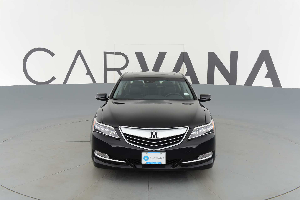

In [10]:
Image.open(PATH/TRAIN_DN/f'{CAR_ID}_01.jpg').resize((300,200))

In [11]:
list((PATH/MASKS_DN).iterdir())[:5]

[PosixPath('data/carvana/train_masks/e5fc2c1c4a8b_06_mask.gif'),
 PosixPath('data/carvana/train_masks/2a4a8964ebf3_11_mask.gif'),
 PosixPath('data/carvana/train_masks/b44091aa62e4_13_mask.gif'),
 PosixPath('data/carvana/train_masks/d1a3af34e674_10_mask.gif'),
 PosixPath('data/carvana/train_masks/245f9c9eab8a_03_mask.gif')]

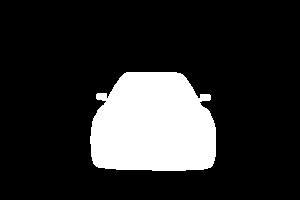

In [12]:
Image.open(PATH/MASKS_DN/f'{CAR_ID}_01_mask.gif').resize((300,200))

In [14]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]

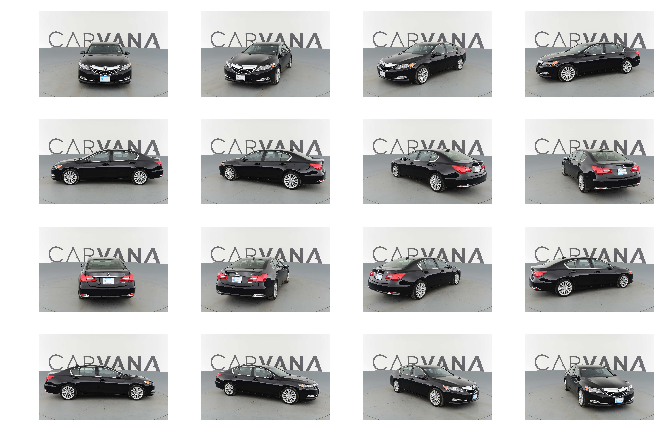

In [18]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

### Resize and convert

In [19]:
(PATH/'train_masks_png').mkdir(exist_ok=True)

In [20]:
def convert_img(fn):
    fn = fn.name
    Image.open(PATH/'train_masks'/fn).save(PATH/'train_masks_png'/f'{fn[:-4]}.png')

In [21]:
files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(convert_img, files)

In [32]:
(PATH/'train_masks-128').mkdir(exist_ok=True)

In [60]:
def resize_mask(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

files = list((PATH/'train_masks_png').iterdir())
# line below was calling resize_img - needs to be updated to call resize_mask
with ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

In [34]:
(PATH/'train-128').mkdir(exist_ok=True)

In [39]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)

files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

## Dataset

In [45]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 64

In [46]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]
im_masks = [open_image(PATH/MASKS_DN/f'{CAR_ID}_{i+1:02d}_mask.png') for i in range(16)]

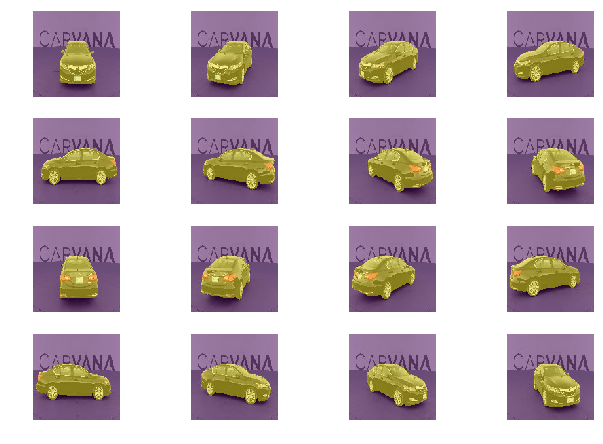

In [47]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [48]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [49]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [75]:
len(x_names)//16//5*16

1008

In [59]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)

(1008, 4080)

In [76]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.PIXEL),
            RandomFlip(tfm_y=TfmType.PIXEL),
            RandomLighting(0.05, 0.05)]
# aug_tfms = []

In [65]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [ ]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)
y = denorm(y)

In [85]:
x[i]

array([[[0.95686, 0.95686, 0.94902],
        [0.95686, 0.95686, 0.94902],
        [0.95294, 0.95294, 0.9451 ],
        ...,
        [0.95294, 0.95294, 0.95294],
        [0.95686, 0.95686, 0.95686],
        [0.95686, 0.95686, 0.95686]],

       [[0.95686, 0.95686, 0.94902],
        [0.95686, 0.95686, 0.94902],
        [0.95294, 0.95294, 0.9451 ],
        ...,
        [0.95294, 0.95294, 0.95294],
        [0.95686, 0.95686, 0.95686],
        [0.95686, 0.95686, 0.95686]],

       [[0.95686, 0.95686, 0.94902],
        [0.95686, 0.95686, 0.94902],
        [0.95294, 0.95294, 0.9451 ],
        ...,
        [0.95294, 0.95294, 0.95294],
        [0.95686, 0.95686, 0.95686],
        [0.95686, 0.95686, 0.95686]],

       ...,

       [[0.85882, 0.83529, 0.78824],
        [0.85882, 0.83529, 0.78824],
        [0.85882, 0.83529, 0.78824],
        ...,
        [0.83529, 0.8    , 0.77255],
        [0.83922, 0.80392, 0.77647],
        [0.84314, 0.80784, 0.78039]],

       [[0.86275, 0.84706, 0.80392],
  

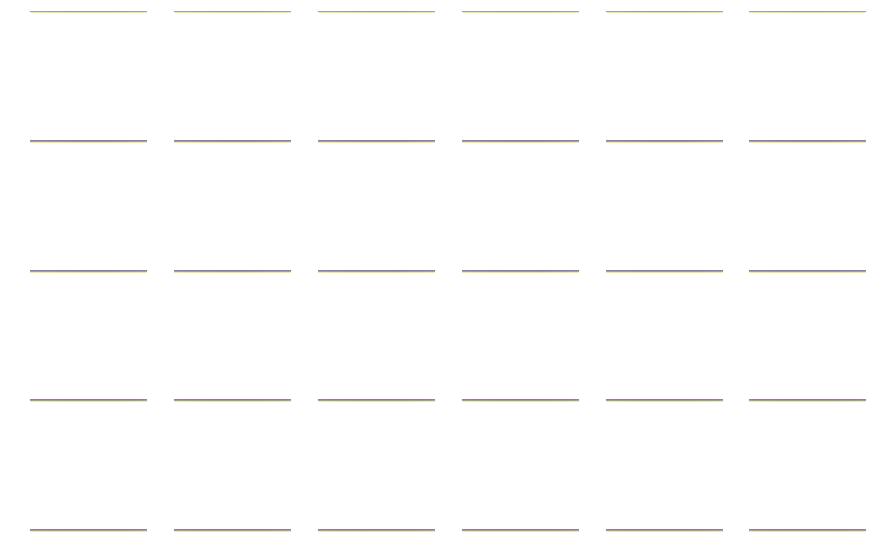

In [67]:
fig, axes = plt.subplots(5, 6, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

## Model

In [155]:
class Empty(nn.Module): 
    def forward(self,x): return x

models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=Empty())
learn = ConvLearner(md, models)
learn.summary()

In [29]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [30]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
)

In [31]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[...,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[...,0], 0.5)

In [32]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc]

A Jupyter Widget

 94%|█████████▍| 30/32 [00:05<00:00,  5.48it/s, loss=10.6] 


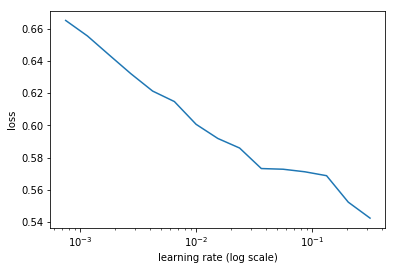

In [82]:
learn.lr_find()
learn.sched.plot()

In [33]:
lr=4e-2

In [34]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

A Jupyter Widget

epoch      trn_loss   val_loss   mask_acc                  
    0      0.18661    0.132661   0.942001  
    1      0.137072   0.122694   0.950788                  
    2      0.118111   0.107621   0.955376                  
    3      0.10659    0.094327   0.957047                  
    4      0.09675    0.088346   0.961379                   



[0.088345617, 0.96137939020991325]

In [35]:
learn.save('tmp')

In [47]:
learn.load('tmp')

In [36]:
py,ay = learn.predict_with_targs()

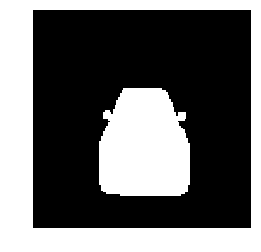

In [37]:
show_img(ay[0]);

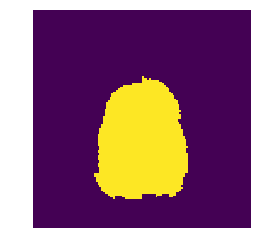

In [38]:
show_img(py[0][0]>0);

In [48]:
learn.unfreeze()

In [49]:
learn.bn_freeze(True)

In [50]:
lrs = np.array([lr/100,lr/10,lr])/4

In [51]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

A Jupyter Widget

epoch      trn_loss   val_loss   mask_acc                   
    0      0.082418   0.054093   0.975919  
    1      0.069207   0.048092   0.978816                   
    2      0.062581   0.042309   0.981247                   
    3      0.059567   0.076317   0.972758                   
    4      0.056221   0.036382   0.985477                   
    5      0.052099   0.033829   0.986771                   
    6      0.050697   0.032404   0.986361                   
    7      0.049282   0.033846   0.985915                   
    8      0.045905   0.029161   0.987637                   
    9      0.044879   0.030073   0.987685                   
    10     0.042145   0.026437   0.988698                   
    11     0.041725   0.026756   0.989043                   
    12     0.041453   0.026988   0.988474                   
    13     0.041565   0.025789   0.989073                   
    14     0.039815   0.025179   0.98982                    
    15     0.039877   0.024658   0.989772

[0.020453382, 0.99203382059931755]

In [62]:
learn.save('0')

In [63]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

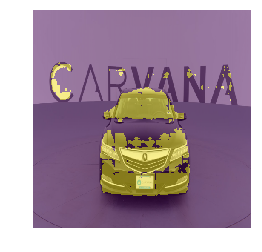

In [64]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

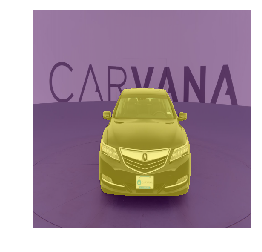

In [65]:
ax = show_img(denorm(x)[0])
show_img(y[0,...,-1], ax=ax, alpha=0.5);

## 512x512

In [56]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 512
bs = 16

In [57]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [58]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)

(1008, 4080)

In [59]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)

In [67]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

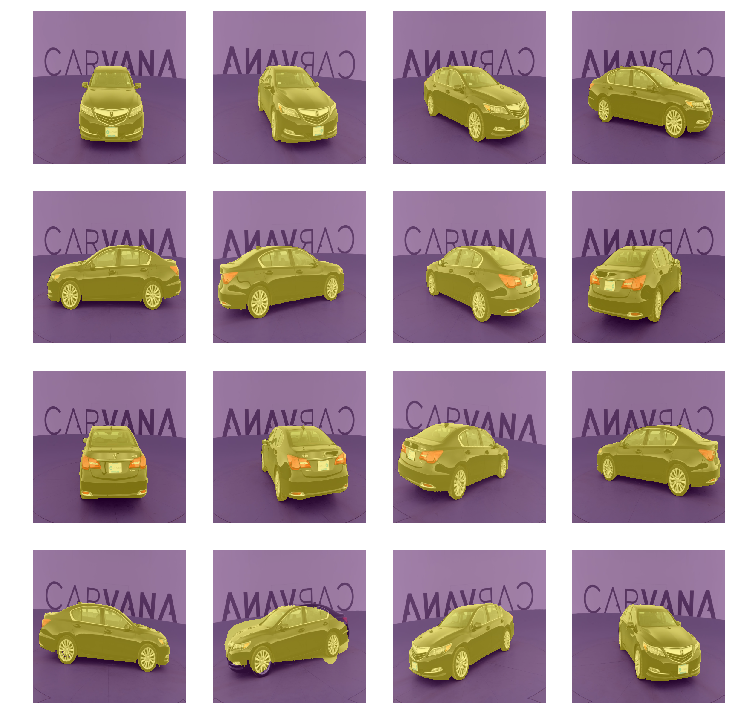

In [68]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [69]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
)

In [70]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc]

In [71]:
learn.load('0')

A Jupyter Widget

 85%|████████▌ | 218/255 [02:12<00:22,  1.64it/s, loss=8.91] 

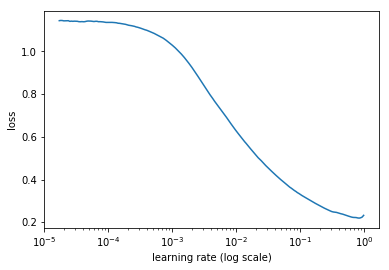

In [21]:
learn.lr_find()
learn.sched.plot()

In [72]:
lr=4e-2

In [73]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

A Jupyter Widget

epoch      trn_loss   val_loss   mask_acc                     
    0      0.030374   0.025171   0.991492  
    1      0.025631   0.019357   0.991213                     
    2      0.024748   0.016949   0.993432                     
    3      0.020972   0.016366   0.992957                     
    4      0.021456   0.015542   0.993686                     



[0.015542077, 0.99368596455407521]

In [74]:
learn.save('tmp')

In [120]:
learn.load('tmp')

In [75]:
learn.unfreeze()
learn.bn_freeze(True)

In [76]:
lrs = np.array([lr/100,lr/10,lr])/4

In [77]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

A Jupyter Widget

epoch      trn_loss   val_loss   mask_acc                     
    0      0.038687   0.018685   0.992782  
    1      0.024906   0.014355   0.994933                     
    2      0.025055   0.014737   0.995526                     
    3      0.024155   0.014083   0.995708                     
    4      0.013446   0.010564   0.996166                     
    5      0.01607    0.010555   0.996096                     
    6      0.019197   0.010883   0.99621                      
    7      0.016157   0.00998    0.996393                     



[0.0099797687, 0.99639255659920833]

In [78]:
learn.save('512')

In [79]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

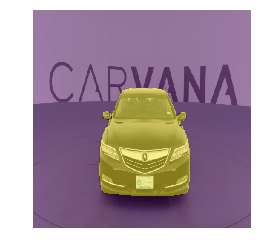

In [80]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

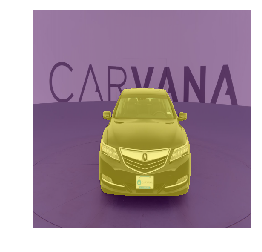

In [81]:
ax = show_img(denorm(x)[0])
show_img(y[0,...,-1], ax=ax, alpha=0.5);

## 1024x1024

In [84]:
sz = 1024
bs = 4

In [85]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)

In [86]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

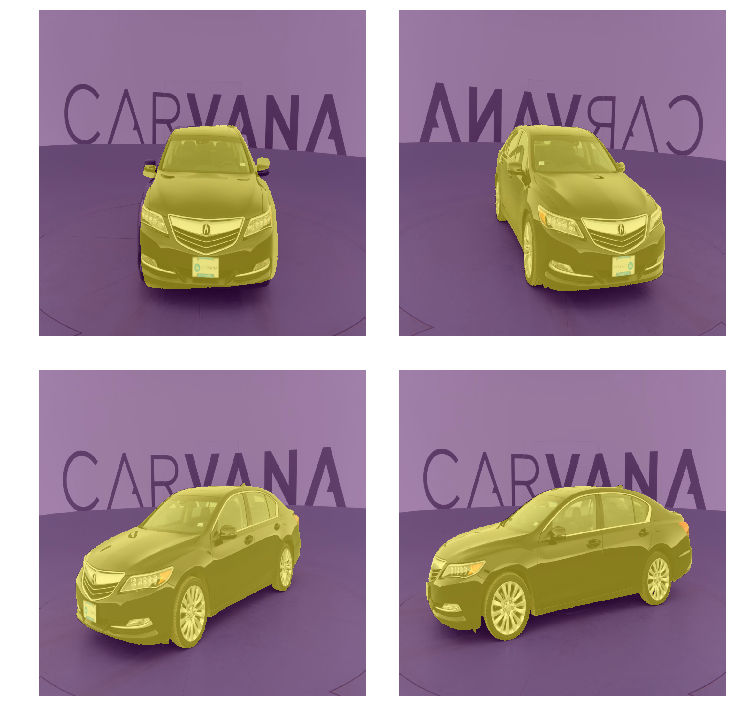

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [88]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
)

In [89]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc]

In [90]:
learn.load('512')

A Jupyter Widget

 85%|████████▌ | 218/255 [02:12<00:22,  1.64it/s, loss=8.91] 

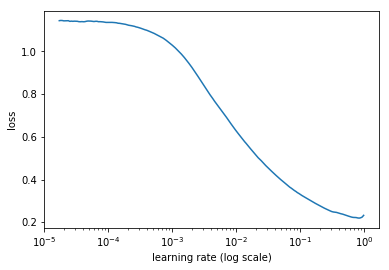

In [21]:
learn.lr_find()
learn.sched.plot()

In [91]:
lr=4e-2

In [92]:
learn.fit(lr,1,cycle_len=2,use_clr=(20,4))

A Jupyter Widget

epoch      trn_loss   val_loss   mask_acc                       
    0      0.028725   0.016203   0.995697  
    1      0.02658    0.012033   0.996428                       



[0.012033461, 0.996428130164979]

In [93]:
learn.save('tmp')

In [97]:
learn.load('tmp')

In [98]:
learn.unfreeze()
learn.bn_freeze(True)

In [99]:
lrs = np.array([lr/100,lr/10,lr])/8

In [100]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

A Jupyter Widget

  0%|          | 3/1020 [00:02<13:50,  1.22it/s, loss=0.0142] 


Exception in thread Thread-81:
Traceback (most recent call last):
  File "/home/jhoward/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jhoward/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jhoward/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   mask_acc                       
    0      0.026908   0.011548   0.996912  
    1      0.018928   0.009143   0.99733                        
    2      0.018891   0.008685   0.997478                       
    3      0.01883    0.007787   0.997747                       



[0.0077870861, 0.99774657355414498]

In [102]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

A Jupyter Widget

epoch      trn_loss   val_loss   mask_acc                       
    0      0.015565   0.007449   0.997661  
    1      0.01979    0.008376   0.997542                       
    2      0.014874   0.007826   0.997736                       
    3      0.016104   0.007854   0.997347                       
    4      0.023386   0.009745   0.997218                       
    5      0.018972   0.008453   0.997588                       
    6      0.013184   0.007612   0.997588                       
    7      0.010686   0.006775   0.997688                       
    8      0.0293     0.015299   0.995782                       
    9      0.018713   0.00763    0.997638                       
    10     0.015432   0.006575   0.9978                         
    11     0.110205   0.060062   0.979043                      
    12     0.014374   0.007753   0.997451                       
    13     0.022286   0.010282   0.997587                       
    14     0.015645   0.00739    0.997776      

[0.0056782686, 0.99817223208291195]

In [103]:
learn.save('1024')

In [104]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

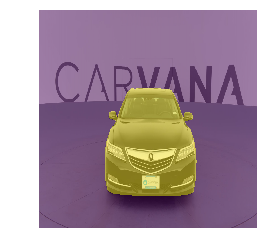

In [105]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

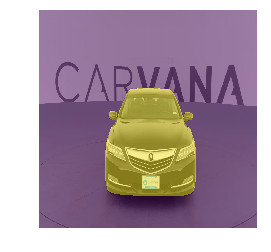

In [106]:
ax = show_img(denorm(x)[0])
show_img(y[0,...,-1], ax=ax, alpha=0.5);

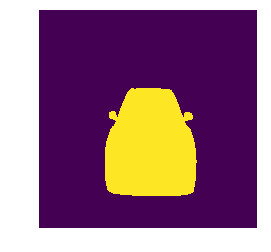

In [107]:
show_img(py[0][0]>0);

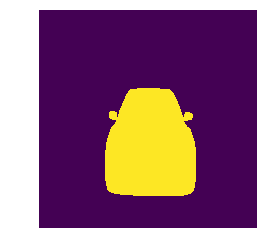

In [108]:
show_img(y[0,...,-1]);

## Fin

In [277]:
x,y = next(iter(md.val_dl))

In [278]:
py = to_np(learn.model(V(x)))

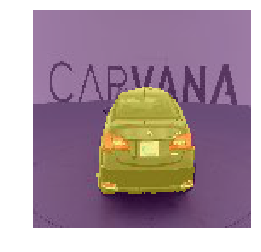

In [279]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

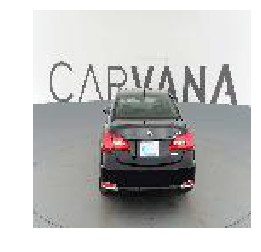

In [269]:
ax = show_img(denorm(x)[0])
